# Avuzu CTR Models


## Imports

### Import libraries


In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import dask.dataframe as dask_data
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

In [119]:
plt.style.use('ggplot')

#A parse date variable to pass in the read_csv function later to take into account the date format 
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

### Import Data


#### Sampling

In [120]:
''' Specifying a sample of the original training data 
    Training data size == 5.87 gigabytes 
    Number of records === 40428966 (excess of 40 million records)
    
    Using random sampling to select a sample of 100 records 
'''

import random
n = 40428966  #total number of records in the clickstream data 
sample_size = 10
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

#Tracking the indices of rows to be skipped at random in the next stage i.e the LOADING stage 


In [121]:
''' LOADING stage 
    Reading the sampled train data
    Size :100 records
'''

train_data = pd.read_csv('avuz_train.csv', parse_dates = ['hour'], date_parser = parse_date,
                        skiprows = skip_values )



In [122]:
'''
Memory optimization at this point ~~ 183 megabytes 

Optimization technique ::: Alter data types from int64 to int32 to reduce block memory usage

Then RELOADING the data 
'''
data_types = {
    'id': np.str,
    'click': np.bool_,
    'hour': np.str,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16
}

train_data = pd.read_csv('avuz_train.csv', parse_dates = ['hour'],
                        date_parser = parse_date, skiprows = skip_values , 
                        dtype = data_types )




In [123]:
train_data_clicks = train_data[train_data['click']==1]

In [124]:
train_data.info() 


## Memory consumption reduced to 107.8 + MB

'''
% reduction in memory usage = 40% 
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 24 columns):
id                  11 non-null object
click               11 non-null bool
hour                11 non-null datetime64[ns]
C1                  11 non-null uint16
banner_pos          11 non-null uint16
site_id             11 non-null object
site_domain         11 non-null object
site_category       11 non-null object
app_id              11 non-null object
app_domain          11 non-null object
app_category        11 non-null object
device_id           11 non-null object
device_ip           11 non-null object
device_model        11 non-null object
device_type         11 non-null uint16
device_conn_type    11 non-null uint16
C14                 11 non-null uint16
C15                 11 non-null uint16
C16                 11 non-null uint16
C17                 11 non-null uint16
C18                 11 non-null uint16
C19                 11 non-null uint16
C20                 11 non-null u

'\n% reduction in memory usage = 40% \n'

In [125]:
train_data.describe() 

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,11.000000,11.0,11.0,11.000000,11.000000,11.0,11.0,11.000000,11.000000,11.000000,11.000000,11.000000
mean,1005.636364,0.0,1.0,0.181818,17605.181818,320.0,50.0,1974.181818,1.818182,238.454545,40195.636364,118.727273
std,2.110579,0.0,0.0,0.603023,7353.908033,0.0,0.0,846.674060,1.470930,391.902121,12528.219604,94.266740
min,1005.000000,0.0,1.0,0.000000,1037.000000,320.0,50.0,178.000000,0.000000,35.000000,34477.000000,15.000000
25%,1005.000000,0.0,1.0,0.000000,16937.500000,320.0,50.0,1880.000000,0.000000,39.000000,34548.000000,23.000000
50%,1005.000000,0.0,1.0,0.000000,20391.000000,320.0,50.0,2340.000000,3.000000,41.000000,34575.000000,156.000000
75%,1005.000000,0.0,1.0,0.000000,22441.500000,320.0,50.0,2545.000000,3.000000,293.000000,34649.000000,216.500000
max,1012.000000,0.0,1.0,2.000000,23561.000000,320.0,50.0,2691.000000,3.000000,1327.000000,65535.000000,221.000000


In [126]:
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1053614435724340610,False,2014-10-22 10:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,7358e05e,b9528b13,...,1,0,1037,320,50,178,3,1327,34477,15
1,5922497456725743434,False,2014-10-24 15:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22259,320,50,2545,0,167,34548,221
2,8256463685744666095,False,2014-10-24 18:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,64fb3325,d9b5648e,...,1,0,20391,320,50,2340,3,41,34575,159
3,17723813729354969275,False,2014-10-26 18:00:00,1012,0,c21df24f,c4e18dd6,f028772b,ecad2386,7801e8d9,...,1,2,17875,320,50,2036,3,47,34575,156
4,9886545084137763826,False,2014-10-27 17:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,6557,320,50,571,2,39,34513,32


In [127]:

'''
24 features encompassing site attributes, application features, device attributes 

Target features - click 
>>C14 - C21 - Anonymized categorical variables 

Features kept anonymous via. md5 hashing encrypton : 
  
>>Site features - Site_id, Site_domain, Site_category
>>App features - app_id, app_domain 
>>Device features - device_type, device_conn_type 

'''

train_data.iloc[:, :24].head(5)


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1053614435724340610,False,2014-10-22 10:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,7358e05e,b9528b13,...,1,0,1037,320,50,178,3,1327,34477,15
1,5922497456725743434,False,2014-10-24 15:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22259,320,50,2545,0,167,34548,221
2,8256463685744666095,False,2014-10-24 18:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,64fb3325,d9b5648e,...,1,0,20391,320,50,2340,3,41,34575,159
3,17723813729354969275,False,2014-10-26 18:00:00,1012,0,c21df24f,c4e18dd6,f028772b,ecad2386,7801e8d9,...,1,2,17875,320,50,2036,3,47,34575,156
4,9886545084137763826,False,2014-10-27 17:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,6557,320,50,571,2,39,34513,32


'\n'

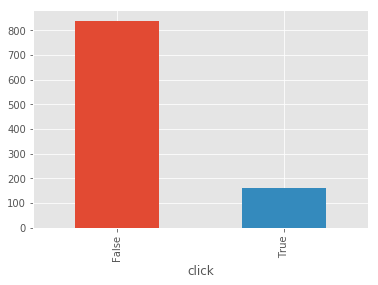

In [11]:
%matplotlib inline

train_data.groupby('click').size().plot(kind = 'bar')
rows = train_data.shape[0]

click_through_rate = train_data['click'].value_counts()/rows 

click_through_rate

'''
'''

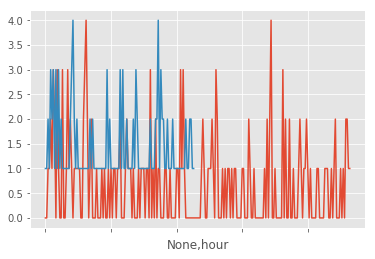

In [12]:
'''
Metric 1. HOUR 
'''

train_data.hour.describe() 


'''INSIGHT 2: Impressions V/S Clicks 
    MAXIMUM number of Impresisons around 1 P.M ~ 1561 '''

df_impressions = train_data.groupby('hour').agg({'click':'sum'})
#df_impressions
df_impressions.unstack().plot()

df_click = train_data[train_data['click']==1]
temp_click = df_click.groupby('hour').agg({'click' : 'sum'})
temp_click.unstack().plot()

#temp_click

In [13]:
train_data.hour.describe()

count                    1001
unique                    233
top       2014-10-22 11:00:00
freq                       14
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

In [14]:
''' HOUR as a metric is difficult to read because it is a time stamp 
    Introducing new metrics: 
     1. hour_in_day - Better KPI to assess the impressions v/s clicks behavior w.r.t hour in day
     2. weekday -- To study user behavior w.r.t clicks on each day 
     3. Day_name -- To extract the day name from the HOUR feature for a better understanding 
'''

train_data['hour_in_day'] = train_data['hour'].apply(lambda val : val.hour)
train_data_clicks['hour_in_day'] = train_data_clicks['hour'].apply(lambda val : val.hour)

train_data['weekday'] = train_data['hour'].apply(lambda val: val.dayofweek)
train_data_clicks['weekday'] = train_data_clicks['hour'].apply(lambda val: val.dayofweek)

train_data['day_name'] = train_data['hour'].apply(lambda x: x.strftime('%A'))
train_data_clicks['day_name'] = train_data_clicks['hour'].apply(lambda x: x.strftime('%A'))



D:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

In [15]:
train_data.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_in_day',
       'weekday', 'day_name'],
      dtype='object')

In [16]:
train_data['hour_in_day'].nunique() #~ 0 TO 23 

24

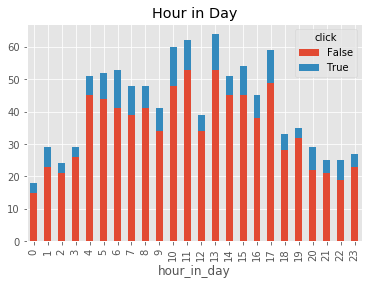

In [17]:
train_data.groupby(['hour_in_day', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Hour in Day")

In [18]:
train_data[['hour','click']].groupby(['hour']).sum().sort_values('click',ascending=False)

,click
hour,
2014-10-28 11:00:00,4.0
2014-10-22 07:00:00,4.0
2014-10-21 09:00:00,3.0
2014-10-25 15:00:00,3.0
2014-10-28 20:00:00,3.0
2014-10-22 06:00:00,3.0
2014-10-26 16:00:00,3.0
2014-10-21 17:00:00,3.0
2014-10-21 13:00:00,3.0


In [19]:
train_data_clicks[['hour','click']].groupby(['hour']).sum().sort_values('click',ascending=False) #do the other way TRUE

,click
hour,
2014-10-22 07:00:00,4.0
2014-10-28 11:00:00,4.0
2014-10-25 13:00:00,3.0
2014-10-21 13:00:00,3.0
2014-10-22 06:00:00,3.0
2014-10-28 20:00:00,3.0
2014-10-21 17:00:00,3.0
2014-10-24 10:00:00,3.0
2014-10-25 15:00:00,3.0


In [20]:
train_data_clicks.head(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
7,14977133658887087307,True,2014-10-21 02:00:00,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,...,300,250,2295,2,35,65535,23,2,1,Tuesday
10,15099039528227445786,True,2014-10-21 03:00:00,1002,0,85f751fd,c4e18dd6,50e219e0,ccf7ce7e,7801e8d9,...,320,50,2480,3,299,34575,61,3,1,Tuesday
14,14595326952203581025,True,2014-10-21 04:00:00,1005,0,4b0f0061,7195bdd6,f028772b,ecad2386,7801e8d9,...,320,50,576,2,35,65535,32,4,1,Tuesday
17,791431643521506605,True,2014-10-21 04:00:00,1005,0,78d60190,1b32ed33,70fb0e29,ecad2386,7801e8d9,...,320,50,2282,3,35,65535,117,4,1,Tuesday
21,17551243844750108076,True,2014-10-21 05:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,65535,79,5,1,Tuesday


In [21]:
hour_df = pd.DataFrame() 

In [22]:
hour_df['hr'] = train_data_clicks[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['hour_in_day']
                        
hour_df

train_data_clicks.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_in_day,weekday,day_name
7,14977133658887087307,True,2014-10-21 02:00:00,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,...,300,250,2295,2,35,65535,23,2,1,Tuesday
10,15099039528227445786,True,2014-10-21 03:00:00,1002,0,85f751fd,c4e18dd6,50e219e0,ccf7ce7e,7801e8d9,...,320,50,2480,3,299,34575,61,3,1,Tuesday
14,14595326952203581025,True,2014-10-21 04:00:00,1005,0,4b0f0061,7195bdd6,f028772b,ecad2386,7801e8d9,...,320,50,576,2,35,65535,32,4,1,Tuesday
17,791431643521506605,True,2014-10-21 04:00:00,1005,0,78d60190,1b32ed33,70fb0e29,ecad2386,7801e8d9,...,320,50,2282,3,35,65535,117,4,1,Tuesday
21,17551243844750108076,True,2014-10-21 05:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,65535,79,5,1,Tuesday


In [23]:
#Taking into account just the CLICKS 

hour_df['pos_clicks'] = train_data_clicks[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['click']
            


In [24]:
#Taking into account the IMPRESSIONS

hour_df['impressions_total'] = train_data[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['click']
            
hour_df


,hr,pos_clicks,impressions_total
6,6,12,53
10,10,12,60
13,13,11,64
17,17,10,59
7,7,9,48
11,11,9,62
15,15,9,54
5,5,8,52
9,9,7,41
16,16,7,45


In [25]:
#Introducing a new feature click through rate 

hour_df['click_through_rate'] = 100*hour_df['pos_clicks']/hour_df['impressions_total']

hour_df.sort_values(ascending = False, by = 'click_through_rate')


,hr,pos_clicks,impressions_total,click_through_rate
20,20,7,29,24.137931
22,22,6,25,24.000000
6,6,12,53,22.641509
1,1,6,29,20.689655
10,10,12,60,20.000000
7,7,9,48,18.750000
13,13,11,64,17.187500
9,9,7,41,17.073171
17,17,10,59,16.949153
0,0,3,18,16.666667


In [26]:
list_of_hours = hour_df.sort_values(by='click_through_rate',ascending=False)['hr'].tolist()

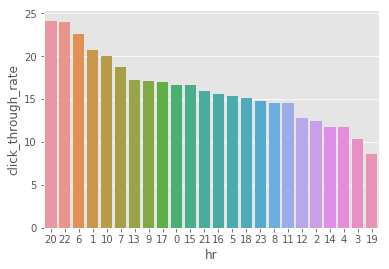

In [27]:
import seaborn as sns
sns.barplot(y='click_through_rate',x='hr'\
            ,data=hour_df\
            ,order=list_of_hours) #nice axis...

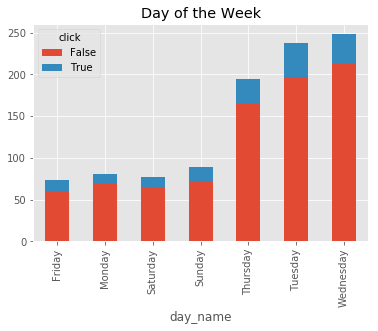

In [28]:
train_data.groupby(['day_name','click']).size().unstack().plot(kind='bar', stacked=True, title="Day of the Week")

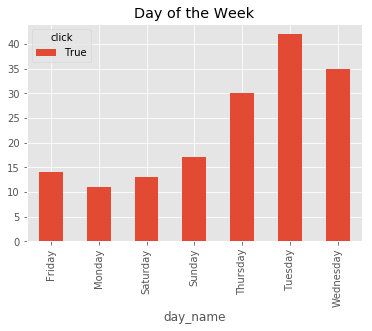

In [29]:
train_data_clicks.groupby(['day_name','click']).size().unstack().plot(kind='bar', stacked=True, title="Day of the Week")

In [30]:
train_data_clicks[['day_name','click']].groupby(['day_name']).count().sort_values('click',ascending=False)

,click
day_name,
Tuesday,42
Wednesday,35
Thursday,30
Sunday,17
Friday,14
Saturday,13
Monday,11


In [31]:
day_df = pd.DataFrame()

In [32]:
day_df['day'] = train_data_clicks[['day_name','click']].groupby(['day_name']).count().reset_index().sort_values('click',ascending=False)['day_name']
day_df 

,day
5,Tuesday
6,Wednesday
4,Thursday
3,Sunday
0,Friday
2,Saturday
1,Monday


In [33]:
day_df['pos_clicks'] = train_data_clicks[['day_name','click']]\
                        .groupby(['day_name']).count()\
                        .reset_index()\
                        .sort_values('click',ascending=False)['click']
day_df

,day,pos_clicks
5,Tuesday,42
6,Wednesday,35
4,Thursday,30
3,Sunday,17
0,Friday,14
2,Saturday,13
1,Monday,11


In [34]:
day_df['total_impressions'] = train_data[['day_name','click']].groupby(['day_name']).count().reset_index().sort_values('click',ascending=False)['click']
day_df

,day,pos_clicks,total_impressions
5,Tuesday,42,238
6,Wednesday,35,248
4,Thursday,30,194
3,Sunday,17,89
0,Friday,14,74
2,Saturday,13,77
1,Monday,11,81


In [35]:
day_df['click_pct'] = 100*day_df['pos_clicks']/day_df['total_impressions']
day_df.sort_values(ascending = False, by = 'click_pct')

,day,pos_clicks,total_impressions,click_pct
3,Sunday,17,89,19.101124
0,Friday,14,74,18.918919
5,Tuesday,42,238,17.647059
2,Saturday,13,77,16.883117
4,Thursday,30,194,15.463918
6,Wednesday,35,248,14.112903
1,Monday,11,81,13.580247


In [36]:
list_of_days = day_df.sort_values(by='click_pct',ascending=False)['day'].tolist()

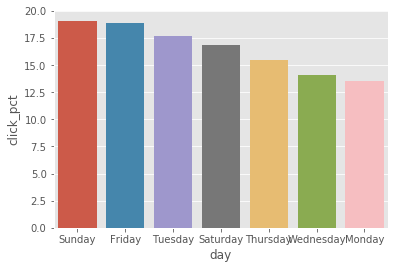

In [37]:
sns.barplot(y='click_pct',x='day'\
            ,data=day_df\
            ,order=list_of_days)

In [38]:
train_data['banner_pos'].unique()

array([0, 1], dtype=uint64)

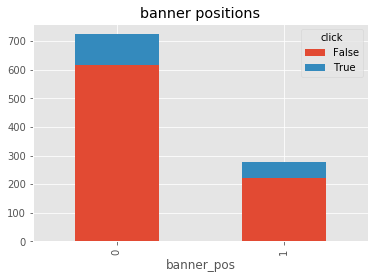

In [39]:
banner_temp =train_data[['banner_pos','click']].groupby(['banner_pos','click'])

banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

In [40]:
train_data[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,724
1,277


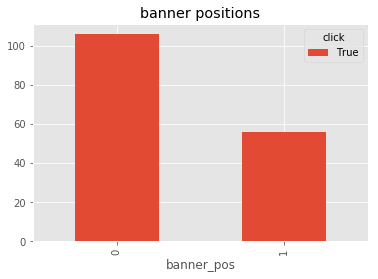

In [41]:
banner_temp =train_data_clicks[['banner_pos','click']].groupby(['banner_pos','click'])

banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

In [42]:
train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,106
1,56


In [43]:
import pandas as pd 

banner_df = pd.DataFrame()

In [44]:
banner_df['position'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['banner_pos']

In [45]:
banner_df['pos_clicks'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']

In [46]:
banner_df['total_impressions'] = train_data[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']

In [47]:
banner_df['click_pct'] = 100*banner_df['pos_clicks']/banner_df['total_impressions']

banner_df

,position,pos_clicks,total_impressions,click_pct
0,0,106,724,14.640884
1,1,56,277,20.216606


In [48]:
banner_df.sort_values(ascending=False,by='click_pct')

,position,pos_clicks,total_impressions,click_pct
1,1,56,277,20.216606
0,0,106,724,14.640884


In [49]:
list_of_banners = banner_df.sort_values(by='click_pct',ascending=False)['position'].tolist()

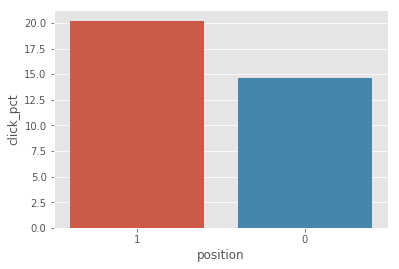

In [50]:
sns.barplot(y='click_pct',x='position'\
            ,data=banner_df\
            ,order=list_of_banners)

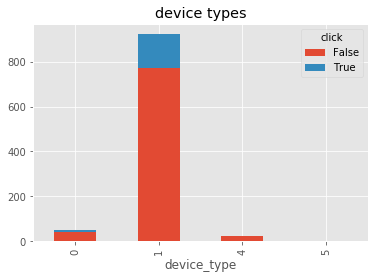

In [51]:
device_temp = train_data[['device_type','click']].groupby(['device_type','click'])

device_temp.size().unstack().plot(kind='bar',stacked=True, title='device types')


In [52]:
train_data[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,921
0,52
4,24
5,4


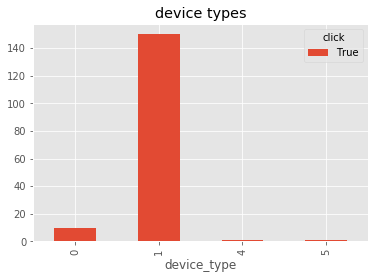

In [53]:
train_data_clicks[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar',stacked=True, title='device types')

In [54]:
train_data_clicks[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,150
0,10
4,1
5,1


In [55]:
device1_df = train_data_clicks[train_data_clicks['device_type']==1]

# extract CLICKS for DEVICE TYPE 1 

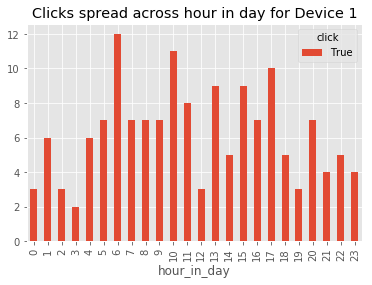

In [56]:
temp_device_df = device1_df.groupby(['hour_in_day', 'click'])

temp_device_df.size().unstack().plot(kind='bar', stacked=True, title="Clicks spread across hour in day for Device 1")

In [57]:
import pandas as pd
dev_type_df=pd.DataFrame()

dev_type_df_total_imp = pd.DataFrame()

In [58]:
#TOTAL CLICKS 

dev_type_df = train_data_clicks.groupby('device_type').agg({'click':'sum'}).reset_index()

dev_type_df

,device_type,click
0,0,10.0
1,1,150.0
2,4,1.0
3,5,1.0


In [59]:
#TOTAL IMPRESSIONS 

dev_type_df_total_imp = train_data.groupby('device_type').agg({'click':'count'}).reset_index()

In [60]:
#dev_type_df_total_imp.drop([2], inplace = True)

dev_type_df_total_imp

,device_type,click
0,0,52
1,1,921
2,4,24
3,5,4


In [61]:
dev_type_df['total_impressions'] = dev_type_df_total_imp['click']

dev_type_df

,device_type,click,total_impressions
0,0,10.0,52
1,1,150.0,921
2,4,1.0,24
3,5,1.0,4


In [62]:
## sucess percentage == CTR 

dev_type_df['success_pct'] = (dev_type_df['click']/dev_type_df['total_impressions'])*100

dev_type_df

,device_type,click,total_impressions,success_pct
0,0,10.0,52,19.230769
1,1,150.0,921,16.286645
2,4,1.0,24,4.166667
3,5,1.0,4,25.000000


In [63]:
dev_type_df_total_imp.columns = ['device_type', 'click2']

merged_df = pd.merge(left = dev_type_df , right = dev_type_df_total_imp,
                    how = 'inner', on = 'device_type')


In [64]:
merged_df

,device_type,click,total_impressions,success_pct,click2
0,0,10.0,52,19.230769,52
1,1,150.0,921,16.286645,921
2,4,1.0,24,4.166667,24
3,5,1.0,4,25.000000,4


In [65]:
merged_df['success_pct'] = 100*(merged_df['click']/merged_df['total_impressions'])

merged_df

,device_type,click,total_impressions,success_pct,click2
0,0,10.0,52,19.230769,52
1,1,150.0,921,16.286645,921
2,4,1.0,24,4.166667,24
3,5,1.0,4,25.000000,4


In [66]:
app_features = ['app_id', 'app_domain', 'app_category']

In [67]:
train_data.groupby('app_category').agg({'click':'sum'}).sort_values(by='click',ascending = False)


,click
app_category,
07d7df22,122.0
0f2161f8,28.0
f95efa07,7.0
8ded1f7a,2.0
8df2e842,1.0
cef3e649,1.0
d1327cf5,1.0
09481d60,0.0
75d80bbe,0.0


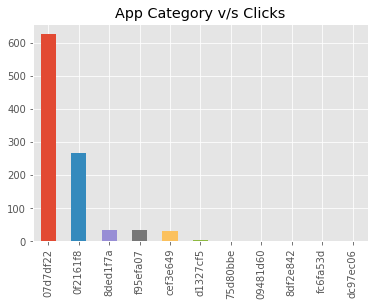

In [68]:
train_data['app_category'].value_counts().plot(kind='bar', title='App Category v/s Clicks')


In [69]:
train_app_category = train_data.groupby(['app_category', 'click']).size().unstack()


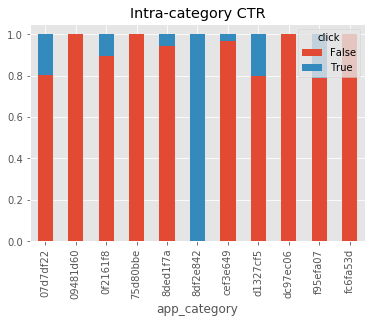

In [70]:

train_app_category.div(train_app_category.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

In [71]:

features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18',
            'C20', 'C21']

train_data[features].astype('object').describe()



,C1,C14,C15,C16,C17,C18,C20,C21
count,1001,1001,1001,1001,1001,1001,1001,1001
unique,5,337,4,5,179,4,70,44
top,1005,21611,320,50,1722,0,65535,23
freq,919,26,943,954,105,410,462,207


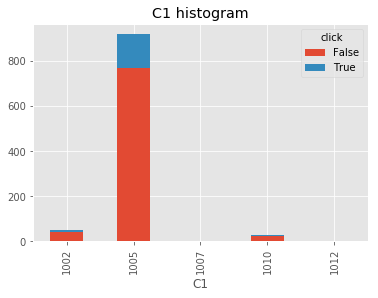

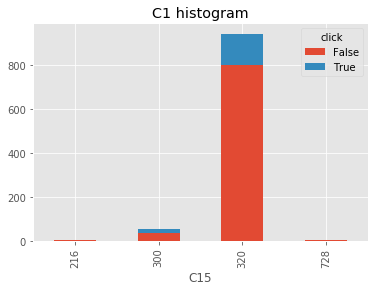

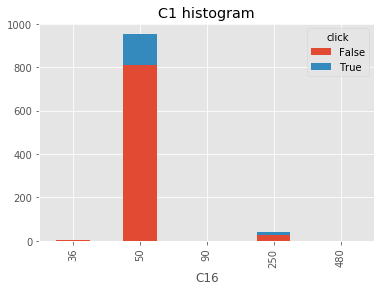

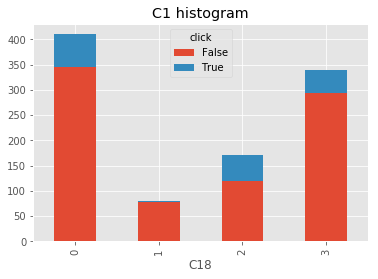

In [72]:
train_data.groupby(['C1', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train_data.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train_data.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train_data.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')


In [73]:
model_features = ['weekday', 'hour_in_day',
                  'banner_pos', 'site_category',
                  'device_conn_type', 'app_category',
                  'device_type']

In [74]:
model_target = 'click'

In [115]:
train_model = train_data[model_features+[model_target]].sample(frac=0.1,random_state=42)

In [116]:
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                     columns = feature_set,
                                    sparse = True)

    return new_data_frame

In [128]:
train_model = one_hot_features(train_model,
                                ['site_category',
                                 'app_category',
                                 'banner_pos'])

In [129]:
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1053614435724340610,False,2014-10-22 10:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,7358e05e,b9528b13,...,1,0,1037,320,50,178,3,1327,34477,15
1,5922497456725743434,False,2014-10-24 15:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22259,320,50,2545,0,167,34548,221
2,8256463685744666095,False,2014-10-24 18:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,64fb3325,d9b5648e,...,1,0,20391,320,50,2340,3,41,34575,159
3,17723813729354969275,False,2014-10-26 18:00:00,1012,0,c21df24f,c4e18dd6,f028772b,ecad2386,7801e8d9,...,1,2,17875,320,50,2036,3,47,34575,156
4,9886545084137763826,False,2014-10-27 17:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,6557,320,50,571,2,39,34513,32


In [130]:
model_features = np.array(train_model.columns[train_model.columns!=model_target].tolist())

In [131]:
from sklearn.model_selection import train_test_split

In [132]:
#from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    train_model[model_features].values,
    train_model[model_target].values,
    test_size=0.25,
    random_state=42
)

In [133]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score


In [134]:
num_splits = 3
c_values = np.logspace(-3,0,7)


In [135]:
stratified_k_fold = StratifiedKFold(n_splits=num_splits)

scores = np.zeros(7)
nr_params = np.zeros(7)


In [86]:
from sklearn.model_selection import train_test_split
results = train_test_split(
        inputs,
        target, 
        test_size = 0.2,
        random_state = 42
)

## Linear Regression

In [154]:
for train_data, valid_data in stratified_k_fold.split(x_train,
                                                      y_train):
    for i, c in enumerate(np.logspace(-3, 0, 7)):
        lr_classify = LogisticRegression(penalty='l1',
                                         class_weight='balanced',
                                         C = c)
        lr_classify.fit(x_train[train_data],
                        y_train[train_data])

        #validation_Set evaluation

        y_prediction = lr_classify.predict(x_train[valid_data])
        score_f1 = f1_score(y_train[valid_data],
                            y_prediction, average='weighted' )

        scores[i] += score_f1 / num_splits

        ### spot the selected parameters ##

        model_selected = SelectFromModel(lr_classify, prefit=True)
        nr_params[i] += np.sum(model_selected.get_support()) / num_splits



Text(0, 0.5, 'Avg F1 score')

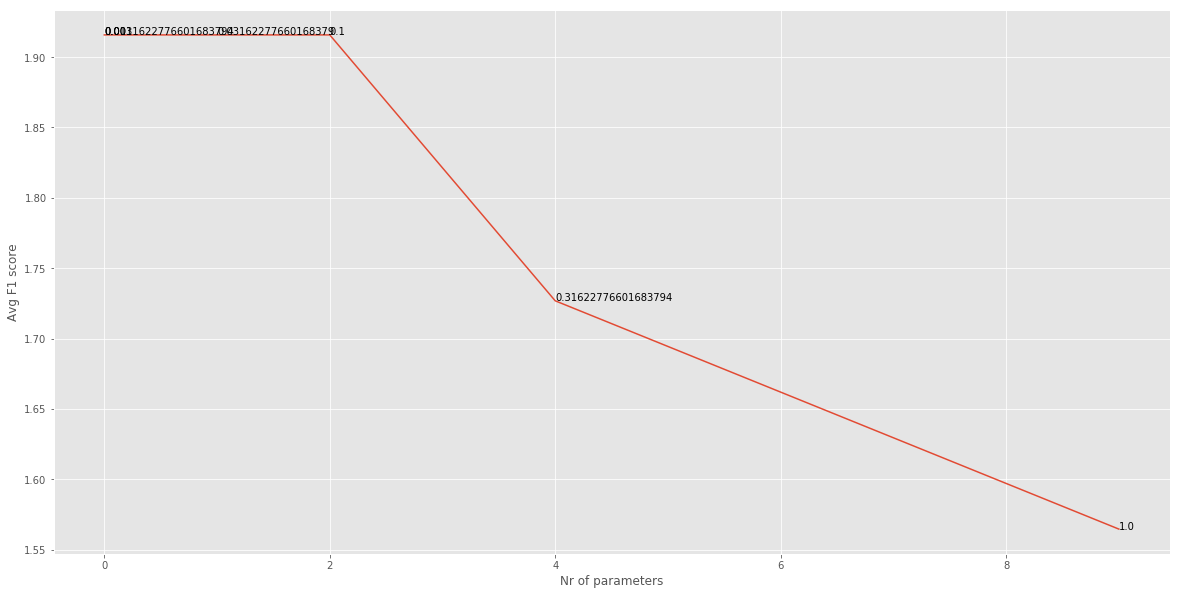

In [155]:
plt.figure(figsize=(20, 10))
plt.plot(nr_params, scores)

for i, c in enumerate(c_values):
    plt.annotate(c, (nr_params[i], scores[i]))
plt.xlabel("Nr of parameters")
plt.ylabel("Avg F1 score")


In [156]:
lr_classify = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [157]:
lr_classify.fit(x_train, y_train)


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [158]:
model_selected = SelectFromModel(lr_classify,
                                 prefit=True )

In [159]:
pruned_params = model_selected.get_support()
pruned_params

array([ True])

In [160]:
model_features = model_features[pruned_params]

x_train = x_train[:, pruned_params]

x_test = x_test[:, pruned_params]


In [161]:
## XGBoost

In [162]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


In [163]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train,
    y_train,
    stratify=y_train,
    test_size=0.1,
    random_state=42)

In [164]:
model = XGBClassifier()
xgb_clf = model

In [165]:
xgb_clf.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="logloss", eval_set=[(x_valid, y_valid)])

[0]	validation_0-logloss:0.681035
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.671862
[2]	validation_0-logloss:0.669793
[3]	validation_0-logloss:0.664124
[4]	validation_0-logloss:0.660209
[5]	validation_0-logloss:0.657601
[6]	validation_0-logloss:0.65614
[7]	validation_0-logloss:0.655616
[8]	validation_0-logloss:0.659748
[9]	validation_0-logloss:0.660367
[10]	validation_0-logloss:0.669882
[11]	validation_0-logloss:0.673419
[12]	validation_0-logloss:0.684224
[13]	validation_0-logloss:0.688189
[14]	validation_0-logloss:0.698877
[15]	validation_0-logloss:0.703297
[16]	validation_0-logloss:0.713815
[17]	validation_0-logloss:0.722674
Stopping. Best iteration:
[7]	validation_0-logloss:0.655616



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [166]:
y_pred = xgb_clf.predict(x_test)
predictions = [round(value) for value in y_pred]

In [167]:
print(classification_report(y_test,
                            predictions))

              precision    recall  f1-score   support

       False       0.76      1.00      0.86        19
        True       0.00      0.00      0.00         6

   micro avg       0.76      0.76      0.76        25
   macro avg       0.38      0.50      0.43        25
weighted avg       0.58      0.76      0.66        25



In [149]:
from sklearn import metrics

print(metrics.accuracy_score(y_test, predictions))
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.roc_auc_score(y_test, predictions))


0.76
[[19  0]
 [ 6  0]]
0.5
